In [2]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil
import seaborn as sns
import math
%matplotlib inline

In [3]:
df = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
session_ids = df['session_id'].values
session_ids = [session for session in session_ids[:-1] if isinstance(session, str)]

exclude = ['ecephys_717120_2024-03-06_12-23-53', 'ecephys_713854_2024-03-08_14-54-25', 'ecephys_713854_2024-03-08_16-20-33']
session_ids = [session_id for session_id in session_ids if session_id not in exclude]

In [6]:
# loop through all sessions
# count number of units pass qc and opto qc
# check if exist in longer than 100 sessions 
# check if exist in pre/post stimulation
# check if exist in anti-dromic stimulation
all_sessions = []
all_units = []
all_qc_pass_units = [] # default qc pass
all_real_units = [] # not noise, not artifact
all_tagged_units = []
in_behavior = []
opto_tagging_pre = []
opto_tagging_post = []
anti = []
probes = []
all_p_max = []
all_lat_max_p = []  # latency of max p response
isi_v = []
all_eu = []
all_corr = []
all_amp = []
all_peak = []
all_wf = []
all_wf_2d = []


# p_resp_thresh = 0.5
# lat_resp_thresh = 0.02

target = 'soma'
for session in session_ids:
    session_dir = session_dirs(session)
    if session_dir['curated_dir_curated'] is not None:
        print(f'Processing {session}')
        data_type = 'curated'
        # if session_dir['curated_dir_curated'] is not None:
        #     data_type = 'curated'
        # elif session_dir['curated_dir_raw'] is not None:
        #     data_type = 'raw'
        # else:
        #     continue

        unit_tbl = get_unit_tbl(session, data_type)
        all_units.extend(unit_tbl['unit_id'].tolist())
        all_qc_pass_units.extend(unit_tbl['default_qc'].tolist())  # default qc pass
        # all_real_units.extend(unit_tbl['real_unit'].tolist())
        all_tagged_units.extend(unit_tbl['tagged_loc'].tolist())  # tagged location (e.g. 'soma', 'axon', 'unspecified')
        all_sessions.extend([session]*len(unit_tbl))
        if 'p_max' not in unit_tbl.columns:
            all_p_max.extend(unit_tbl['p_max_x'].tolist())
            all_lat_max_p.extend(unit_tbl['lat_max_p_x'].tolist())
            all_eu.extend(unit_tbl['euc_max_p_x'].tolist())
            all_corr.extend(unit_tbl['corr_max_p_x'].tolist())
            peaks = unit_tbl['peak_x'].values
            amp = unit_tbl['amp_x'].values
        else: 
            all_p_max.extend(unit_tbl['p_max'].tolist())  
            all_lat_max_p.extend(unit_tbl['lat_max_p'].tolist()) 
            all_eu.extend(unit_tbl['euc_max_p'].tolist())
            all_corr.extend(unit_tbl['corr_max_p'].tolist()) 
            peaks = unit_tbl['peak'].values
            amp = unit_tbl['amp'].values
     
        isi_v.extend(unit_tbl['isi_violations_ratio'].tolist())  # ISI violations

        wf_opt = [wf_opt_unit if isinstance(wf_opt_unit, np.ndarray) else wf_unit for wf_opt_unit, wf_unit in zip(unit_tbl['peak_wf_opt'], unit_tbl['peak_wf'])]  # peak waveform

        wf_opt_2d = [wf_opt_unit if isinstance(wf_opt_unit, np.ndarray) else wf_unit for wf_opt_unit, wf_unit in zip(unit_tbl['mat_wf_opt'], unit_tbl['wf_2d'])]  # peak waveform 2D


        amp_opt = [
                        np.max(wf_opt_curr) - np.min(wf_opt_curr) if isinstance(wf_opt_curr, np.ndarray) else curr_amp_unit
                        for wf_opt_curr, curr_amp_unit in zip(wf_opt, amp)
                    ]   # amplitude of optimized waveforms
        peak_opt = [
                        curr_peak_opt_unit if not np.isnan(curr_peak_opt_unit) else curr_peak_unit
                        for curr_peak_opt_unit, curr_peak_unit in zip(list(unit_tbl['amplitude_opt'].values), list(peaks))
                    ]
        
        all_amp.extend(amp_opt)  # amplitude of max p response
        all_peak.extend(peak_opt)  # peak opto response
        all_wf.extend(wf_opt)  # waveform of max p response
        all_wf_2d.extend(wf_opt_2d)  # waveform of max p response



        # session and opto information
        session_df = get_session_tbl(session)
        with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_info_{target}.json')) as f:
            opto_info = json.load(f)
        opto_df = pd.read_csv(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_session_{target}.csv'))
        if len(opto_df[opto_df['pre_post'] == 'pre'])>0:
            pre_end = np.max(opto_df[opto_df['pre_post'] == 'pre']['time'].values)
        else:
            pre_end = np.nan
        
        if len(opto_df[opto_df['pre_post'] == 'post'])>0:
            post_start = np.min(opto_df[opto_df['pre_post'] == 'post']['time'].values)
            post_end = np.max(opto_df[opto_df['pre_post'] == 'post']['time'].values)
        else:
            post_start = np.nan
            post_end = np.nan
            
        for unit_id in unit_tbl['unit_id'].values:
            curr_pre_opto = True
            curr_post_opto = True 
            curr_anti_opto = True  
            if session_df is not None:
                curr_in_beh = True
            else:
                curr_in_beh = False
            unit = unit_tbl[unit_tbl['unit_id'] == unit_id]
            unit_drift = load_drift(session, unit_id, data_type=data_type)
            if session_df is not None:
                go_cue_times = session_df['goCue_start_time']
                if unit_drift is not None:
                    if unit_drift['ephys_cut'][0] is not None:
                        if unit_drift['ephys_cut'][0] > pre_end - 2*60:
                            curr_pre_opto = False 
                        go_cue_times = go_cue_times[go_cue_times >= unit_drift['ephys_cut'][0]]         
                    if unit_drift['ephys_cut'][1] is not None:
                        if unit_drift['ephys_cut'][1] < post_start + 2*60:
                            curr_post_opto = False
                        if unit_drift['ephys_cut'][1] < post_end + 2*60:
                            curr_anti_opto = False
                        go_cue_times = go_cue_times[go_cue_times <= unit_drift['ephys_cut'][1]]
                if len(go_cue_times) < 150:
                    curr_in_beh = False
            opto_tagging_pre. append(curr_pre_opto)
            opto_tagging_post.append(curr_post_opto)
            anti.append(curr_anti_opto)
            in_behavior.append(curr_in_beh)
        probes.extend([df[df['session_id']==session]['probe'].values[0]] * len(unit_tbl))

Processing ecephys_713854_2024-03-05_12-01-40
Processing ecephys_713854_2024-03-05_13-01-09
Processing ecephys_713854_2024-03-05_13-31-20
Processing ecephys_717120_2024-03-06_12-54-27
Processing ecephys_717120_2024-03-07_12-12-02
Processing ecephys_713854_2024-03-08_15-43-01
There is no nwb file in the curated directory.
Processing ecephys_684930_2023-09-27_10-04-04
Processing ecephys_684930_2023-09-28_11-45-27
Processing ecephys_684930_2023-09-28_12-44-15
Processing ecephys_687697_2023-09-15_11-30-06
Processing ecephys_687697_2023-09-15_12-36-06
Processing ecephys_691893_2023-10-05_12-46-57
Processing ecephys_691893_2023-10-06_13-48-18
Processing behavior_716325_2024-05-31_10-31-14
Processing behavior_717121_2024-06-15_10-00-58
There are multiple recordings in the raw nwb directory. Please specify the recording you would like to use.
Processing behavior_751004_2024-12-19_11-50-37
Processing behavior_751004_2024-12-20_13-26-11


KeyError: 'peak_wf'

In [45]:
combined_tagged_units = pd.DataFrame({'session': all_sessions,
                                        'unit': all_units,
                                        'qc_pass': all_qc_pass_units,
                                        'opto_tagged': all_tagged_units,
                                        'opto_tagging_pre': opto_tagging_pre,
                                        'opto_tagging_post': opto_tagging_post,
                                        'anti': anti,
                                        'in_behavior': in_behavior,
                                        'p_max': all_p_max,
                                        'lat_max_p': all_lat_max_p,
                                        'isi_violations': isi_v,
                                        'eu': all_eu,
                                        'corr': all_corr,
                                        'amp': all_amp,
                                        'peak': all_peak,
                                        'wf': all_wf,
                                        'probe': probes,
                                        })

In [50]:
# load constraints
criteria_name = 'waveform_good'
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)

# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)


In [54]:
for col, cfg in constraints.items():
    if col not in combined_tagged_units.columns:
        continue

    # Numeric range?
    if "bounds" in cfg:
        print(f'Applying bounds for {col}: {cfg["bounds"]}')
        lb, ub = np.array(cfg["bounds"], dtype=float)  # np.nan for null
        if not np.isnan(lb):
            mask &= combined_tagged_units[col] >= lb
        if not np.isnan(ub):
            mask &= combined_tagged_units[col] <= ub

    # Categorical list?
    elif "items" in cfg:
        print(f'Applying items for {col}: {cfg["items"]}')
        allowed = cfg["items"]
        mask &= combined_tagged_units[col].isin(allowed)

# apply and get filtered DataFrame
combined_tagged_units_filtered = combined_tagged_units[mask]
combined_tagged_units['selected'] = mask
print(f'Number of units after filtering: {len(combined_tagged_units_filtered)}')

Applying bounds for isi_violations: [0.0, 0.1]
Applying bounds for p_max: [0.5, 1.0]
Applying bounds for lat_max_p: [0.005, 0.02]
Applying bounds for eu: [0.0, 0.25]
Applying bounds for corr: [0.95, 1.0]
Applying items for qc_pass: [True]
Applying items for probe: ['2']
Number of units after filtering: 124


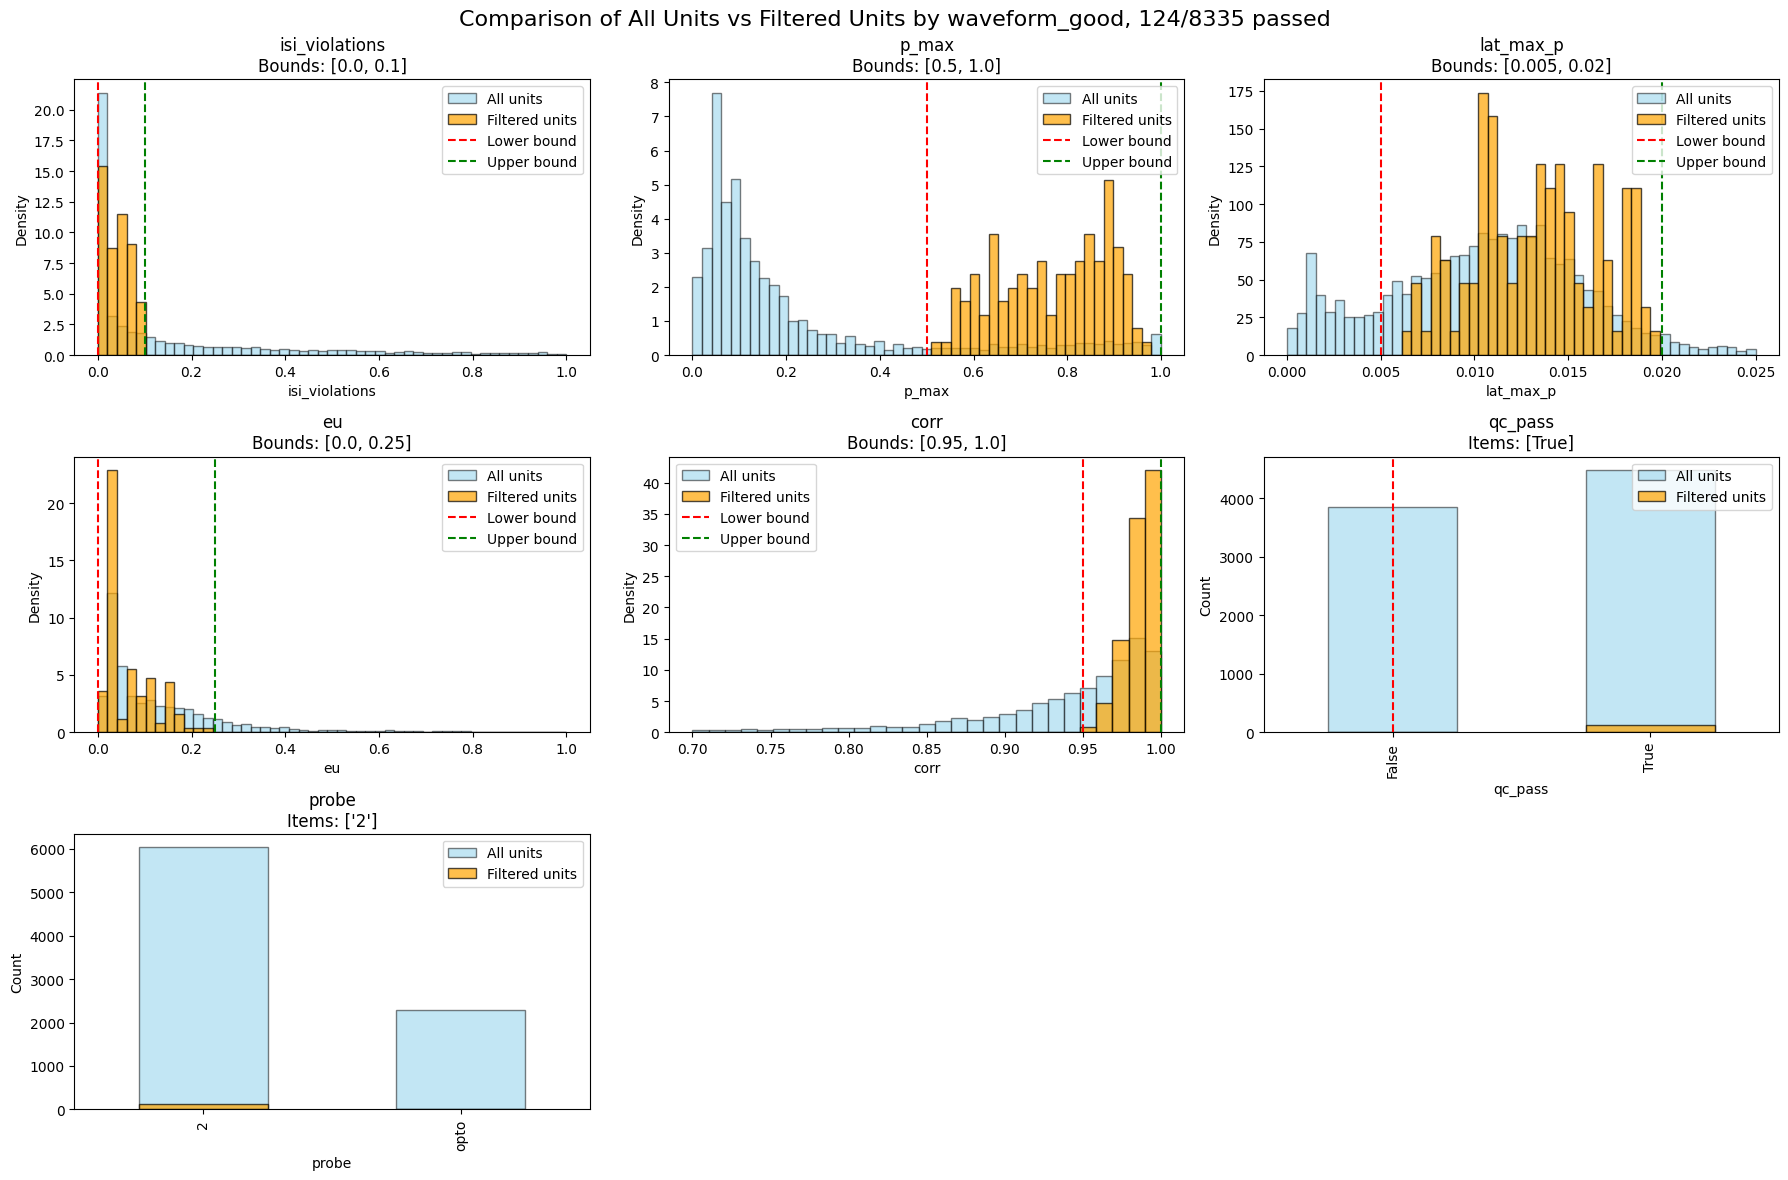

In [80]:
valid_constraints = {col: cfg for col, cfg in constraints.items() if col in combined_tagged_units.columns}
n = len(valid_constraints)

ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
axes = axes.flatten()

for i, (col, cfg) in enumerate(valid_constraints.items()):
    ax = axes[i]
    full_data = combined_tagged_units[col].dropna()
    filtered_data = combined_tagged_units_filtered[col].dropna()

    if "bounds" in cfg:
        lb, ub = np.array(cfg["bounds"], dtype=float)
        bins = 50

        match col:
            case 'isi_violations':
                bins =  np.linspace(0, 1, 50)
            case 'eu':
                bins =  np.linspace(0, 1, 50)
            case 'corr':
                bins =  np.linspace(0.7, 1, 30)
            case 'p_max':
                bins =  np.linspace(0, 1, 50)
            case 'lat_max_p':
                bins =  np.linspace(0, 0.025, 50)
        ax.hist(full_data, bins=bins, color='skyblue', edgecolor='black', alpha=0.5, label='All units', density=True)
        ax.hist(filtered_data, bins=bins, color='orange', edgecolor='black', alpha=0.7, label='Filtered units', density=True)

        ax.set_title(f'{col}\nBounds: [{lb}, {ub}]')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

        if not np.isnan(lb):
            ax.axvline(lb, color='red', linestyle='--', label='Lower bound')
        if not np.isnan(ub):
            ax.axvline(ub, color='green', linestyle='--', label='Upper bound')
        ax.legend()

    elif "items" in cfg:
        full_counts = combined_tagged_units[col].dropna().astype(str).value_counts()
        filtered_counts = combined_tagged_units_filtered[col].dropna().astype(str).value_counts()

        # Get all unique category labels from both datasets
        all_idx = full_counts.index.union(filtered_counts.index)

        # Reindex both with all categories, fill missing with 0
        full_counts = full_counts.reindex(all_idx, fill_value=0)
        filtered_counts = filtered_counts.reindex(all_idx, fill_value=0)

        # Plot
        full_counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.5, edgecolor='black', label='All units')
        filtered_counts.plot(kind='bar', ax=ax, color='orange', alpha=0.7, edgecolor='black', label='Filtered units')



        for item in cfg["items"]:
            if str(item) in counts.index:
                ax.axvline(x=str(item), color='red', linestyle='--')

        ax.set_title(f'{col}\nItems: {cfg["items"]}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend()

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Comparison of All Units vs Filtered Units by {criteria_name}, {len(combined_tagged_units_filtered)}/{len(combined_tagged_units)} passed', fontsize=16)

plt.tight_layout()
plt.show()


In [81]:
import seaborn as sns

sns.pairplot(
    combined_tagged_units[['isi_violations', 'p_max', 'selected', 'peak', 'amp', 'eu', 'corr']],
    hue='selected',
    corner=True,
    diag_kind='hist',
    plot_kws={'alpha': 0.5, 'size': 5}, # 'linewidth': 2, 'facecolor': 'none'},
    diag_kws={'common_norm': False}
)




KeyboardInterrupt: 

In [67]:
combined_tagged_units

,session,unit,qc_pass,opto_tagged,opto_tagging_pre,opto_tagging_post,anti,in_behavior,p_max,lat_max_p,isi_violations,eu,corr,amp,peak,wf,probe,selected
0,ecephys_713854_2024-03-05_12-01-40,0,True,False,True,True,True,False,0.067565,0.007455,0.096176,0.143200,0.956625,227.987358,-168.453079,"[-1.7105398178100586, -0.16496939957141876, 1....",2,False
1,ecephys_713854_2024-03-05_12-01-40,1,True,False,True,True,True,False,0.133974,0.013191,0.000000,0.131646,0.973603,114.918560,-83.020844,"[8.204042434692383, 8.311673164367676, 9.03707...",2,False
2,ecephys_713854_2024-03-05_12-01-40,2,True,False,True,True,True,False,-0.095125,0.013203,0.000000,0.047292,0.996913,810.940948,-504.859406,"[-10.844730377197266, -10.085395812988281, -9....",2,False
3,ecephys_713854_2024-03-05_12-01-40,3,True,False,True,True,True,False,0.030265,0.014006,0.005298,0.050756,0.992733,476.003922,-321.734680,"[4.195621013641357, 5.438158988952637, 8.28008...",2,False
4,ecephys_713854_2024-03-05_12-01-40,4,True,False,True,True,True,False,0.113496,0.015920,0.004686,0.119507,0.985669,157.651642,-117.269058,"[1.8883776664733887, 0.6048895716667175, 2.122...",2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8330,behavior_754897_2025-03-15_11-32-18,152,False,None,True,True,True,True,0.080005,0.022778,0.101747,4.361262,-0.026769,9.620909,-3.354388,"[-0.8821793794631958, 0.42821991443634033, 1.8...",2,False
8331,behavior_754897_2025-03-15_11-32-18,153,False,None,True,True,True,True,0.072964,0.014889,0.074432,0.736887,0.604794,54.472841,-24.290369,"[5.9974212646484375, 7.186136245727539, 8.4626...",2,False
8332,behavior_754897_2025-03-15_11-32-18,154,False,None,True,True,True,True,0.000000,NaN,0.000000,NaN,NaN,149.540611,-62.107498,"[3.7781240940093994, 2.0231244564056396, -0.31...",2,False
8333,behavior_754897_2025-03-15_11-32-18,155,False,None,True,True,True,True,-0.000140,NaN,0.000000,NaN,NaN,132.632484,-56.696247,"[-3.867499351501465, -5.55750036239624, -5.476...",2,False


In [221]:
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
all_wfs = []
all_peaks = []
curr_session = None
for index, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit = row['unit']
    if tag and isi_v_curr < 0.5 and probe.values[0] == '2':
        # check if different session
        if curr_session is None or curr_session != session:
            session_dir = session_dirs(session)
            unit_tbl = get_unit_tbl(session, data_type)
            opto_wf_pkl = os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_waveform_metrics.pkl')
            if os.path.exists(opto_wf_pkl):
                with open (opto_wf_pkl, 'rb') as f:
                    opto_wf = pickle.load(f)
                    opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
            else: 
                opto_wf = None
            curr_session = session
        wf_spont = opto_wf.query('unit_id == @unit and pre_post == "pre" and spont == 1')
        wf_pre = wf_spont['peak_waveform'].values[0] if len(wf_spont) > 0 and pre_opto else None
        wf_spont = opto_wf.query('unit_id == @unit and pre_post == "post" and spont == 1')
        wf_post = wf_spont['peak_waveform'].values[0] if len(wf_spont) > 0 and post_opto else None

        if wf_pre is not None and wf_post is not None:
            amp_pre = wf_pre.max() - wf_pre.min()
            amp_post = wf_post.max() - wf_post.min()
            if amp_pre < amp_post:
                curr_wf = wf_post
            else:
                curr_wf = wf_pre
        elif wf_pre is not None:
            curr_wf = wf_pre
        elif wf_post is not None:
            curr_wf = wf_post  
        else:
            curr_wf = np.full(90, np.nan)  # if no waveform, use zero array
        
        peak = curr_wf[30]  # find the peak of the waveform
        # if peak < 25 or peak + 50 >= len(curr_wf):
        #     curr_wf = curr_wf[5:80]
        # else:
        #     curr_wf = curr_wf[peak-25:peak+50]  # trim the waveform to 90 samples around the peak
        all_wfs.append(curr_wf)
        curr_peak = curr_wf[30]
        all_peaks.append(curr_peak)

/tmp/ipykernel_5988/2939948011.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_5988/2939948011.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_5988/2939948011.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_5988/2939948011.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  opto_wf = opto_wf.apply(pd.t

In [14]:
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
all_wfs = []
all_peaks = [] 
curr_session = None

for row in combined_tagged_units.iterrows():
    session = row[1]['session']
    unit = row[1]['unit']
    tag = row[1]['opto_tagged']
    qc = row[1]['qc_pass']
    pre_opto = row[1]['opto_tagging_pre']
    post_opto = row[1]['opto_tagging_post']
    isi_v_curr = row[1]['isi_violations']
    eu = row[1]['eu']
    corr = row[1]['corr']
    probe = df[df['session_id']==session]['probe']
    if tag and isi_v_curr < 0.5 and probe.values[0] == '2' and eu < 0.25 and corr > 0.95:
        if curr_session is None or curr_session != session:
            print(session)
            session_dir = session_dirs(session)
            unit_tbl = get_unit_tbl(session, data_type)
            curr_session = session
        
        curr_wf = row[1]['peak_wf_opt'].values[0]
        all_wfs.append(curr_wf)
        curr_peak = curr_wf[30]
        all_peaks.append(curr_peak)

ecephys_713854_2024-03-05_12-01-40


KeyError: 'peak_wf_opt'

In [35]:
len(list(set(all_sessions)))

36

In [21]:
print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & combined_tagged_units['in_behavior'] & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and in behavior and tagged'
print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'
print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & (anti) & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'
print((combined_tagged_units['qc_pass'] & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'

100
183
171
2931


/tmp/ipykernel_5988/2749729675.py:3: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  print((combined_tagged_units['opto_tagged'] & combined_tagged_units['qc_pass'] & (anti) & (combined_tagged_units['isi_violations']<0.1)).sum()), 'units passed qc and tagged'


(None, 'units passed qc and tagged')

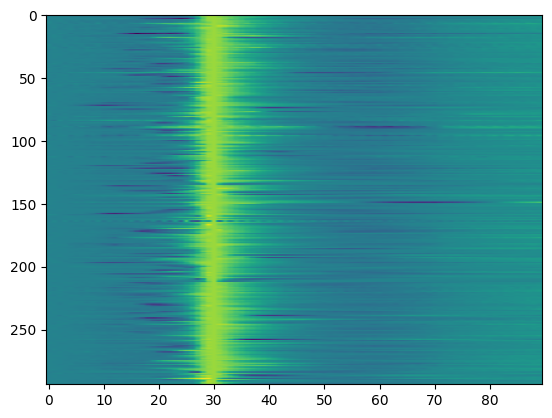

In [230]:
all_wfs = np.array(all_wfs)
baseline = np.mean(all_wfs[:, :5], axis=1, keepdims=True) 
peaks = np.array(all_peaks).reshape(-1, 1) 

all_wfs_nl = (all_wfs - baseline) / (peaks - baseline)

plt.imshow(all_wfs_nl, aspect='auto', cmap='viridis')

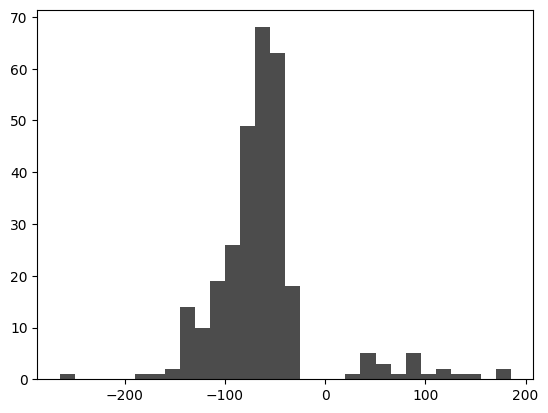

In [223]:
plt.hist(x=np.array(all_peaks), bins=30, color='k', alpha=0.7);


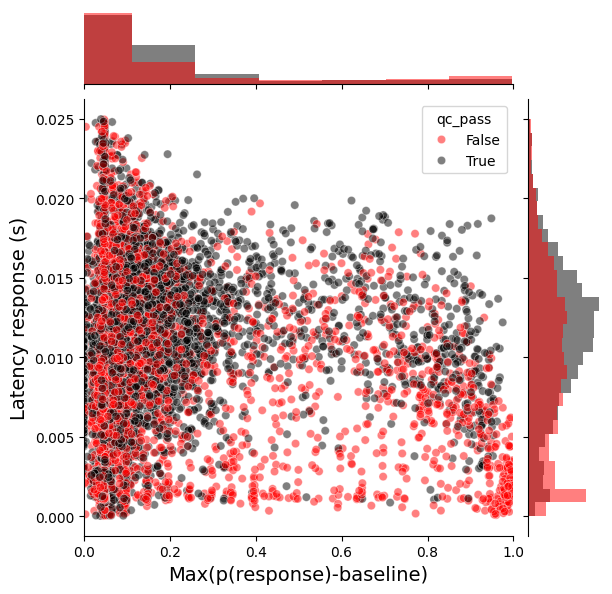

In [206]:
# Define color palette for groups
palette = {True: "k", False: "red"}

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units, x='p_max', y='lat_max_p', hue='qc_pass', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Latency response (s)', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(combined_tagged_units['p_max'].min(), combined_tagged_units['p_max'].max(), 30)
lat_max_p_bins = np.linspace(combined_tagged_units['lat_max_p'].min(), combined_tagged_units['lat_max_p'].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units[combined_tagged_units['qc_pass'] == qc_val]
    
    # Horizontal histogram for x-axis (default orientation)
    sns.histplot(subset['p_max'], ax=g.ax_marg_x, bins=p_max_bins, color=color, alpha=0.5, edgecolor='none')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')


# Show plot
plt.show()


In [231]:
# pca for waveform
from sklearn.decomposition import PCA
from scipy.stats import zscore
# Perform PCA on the waveforms
amp_thresh = -50
# wf_mat = zscore(all_wfs_nl[np.array(all_peaks)<amp_thresh], axis=0, nan_policy='omit')  # z-score normalize the waveforms
# wf_mat = np.delete(wf_mat, 30, axis=1)
# plt.imshow(wf_mat, aspect='auto', cmap='viridis')
# plt.colorbar(label='Normalized Amplitude')
all_wfs_nl_clean = all_wfs_nl[np.array(all_peaks)<amp_thresh, 10:70]


In [232]:
pca = PCA(n_components=8)
pc_time = (np.arange(60) - 20)/30000 * 1000  # assuming 90 samples in the waveform
pca_result = pca.fit_transform(all_wfs_nl_clean)
explained_variance = pca.explained_variance_ratio_
coeff = pca.components_
mean = pca.mean_
all_wfs_pc = pca.inverse_transform(pca_result)


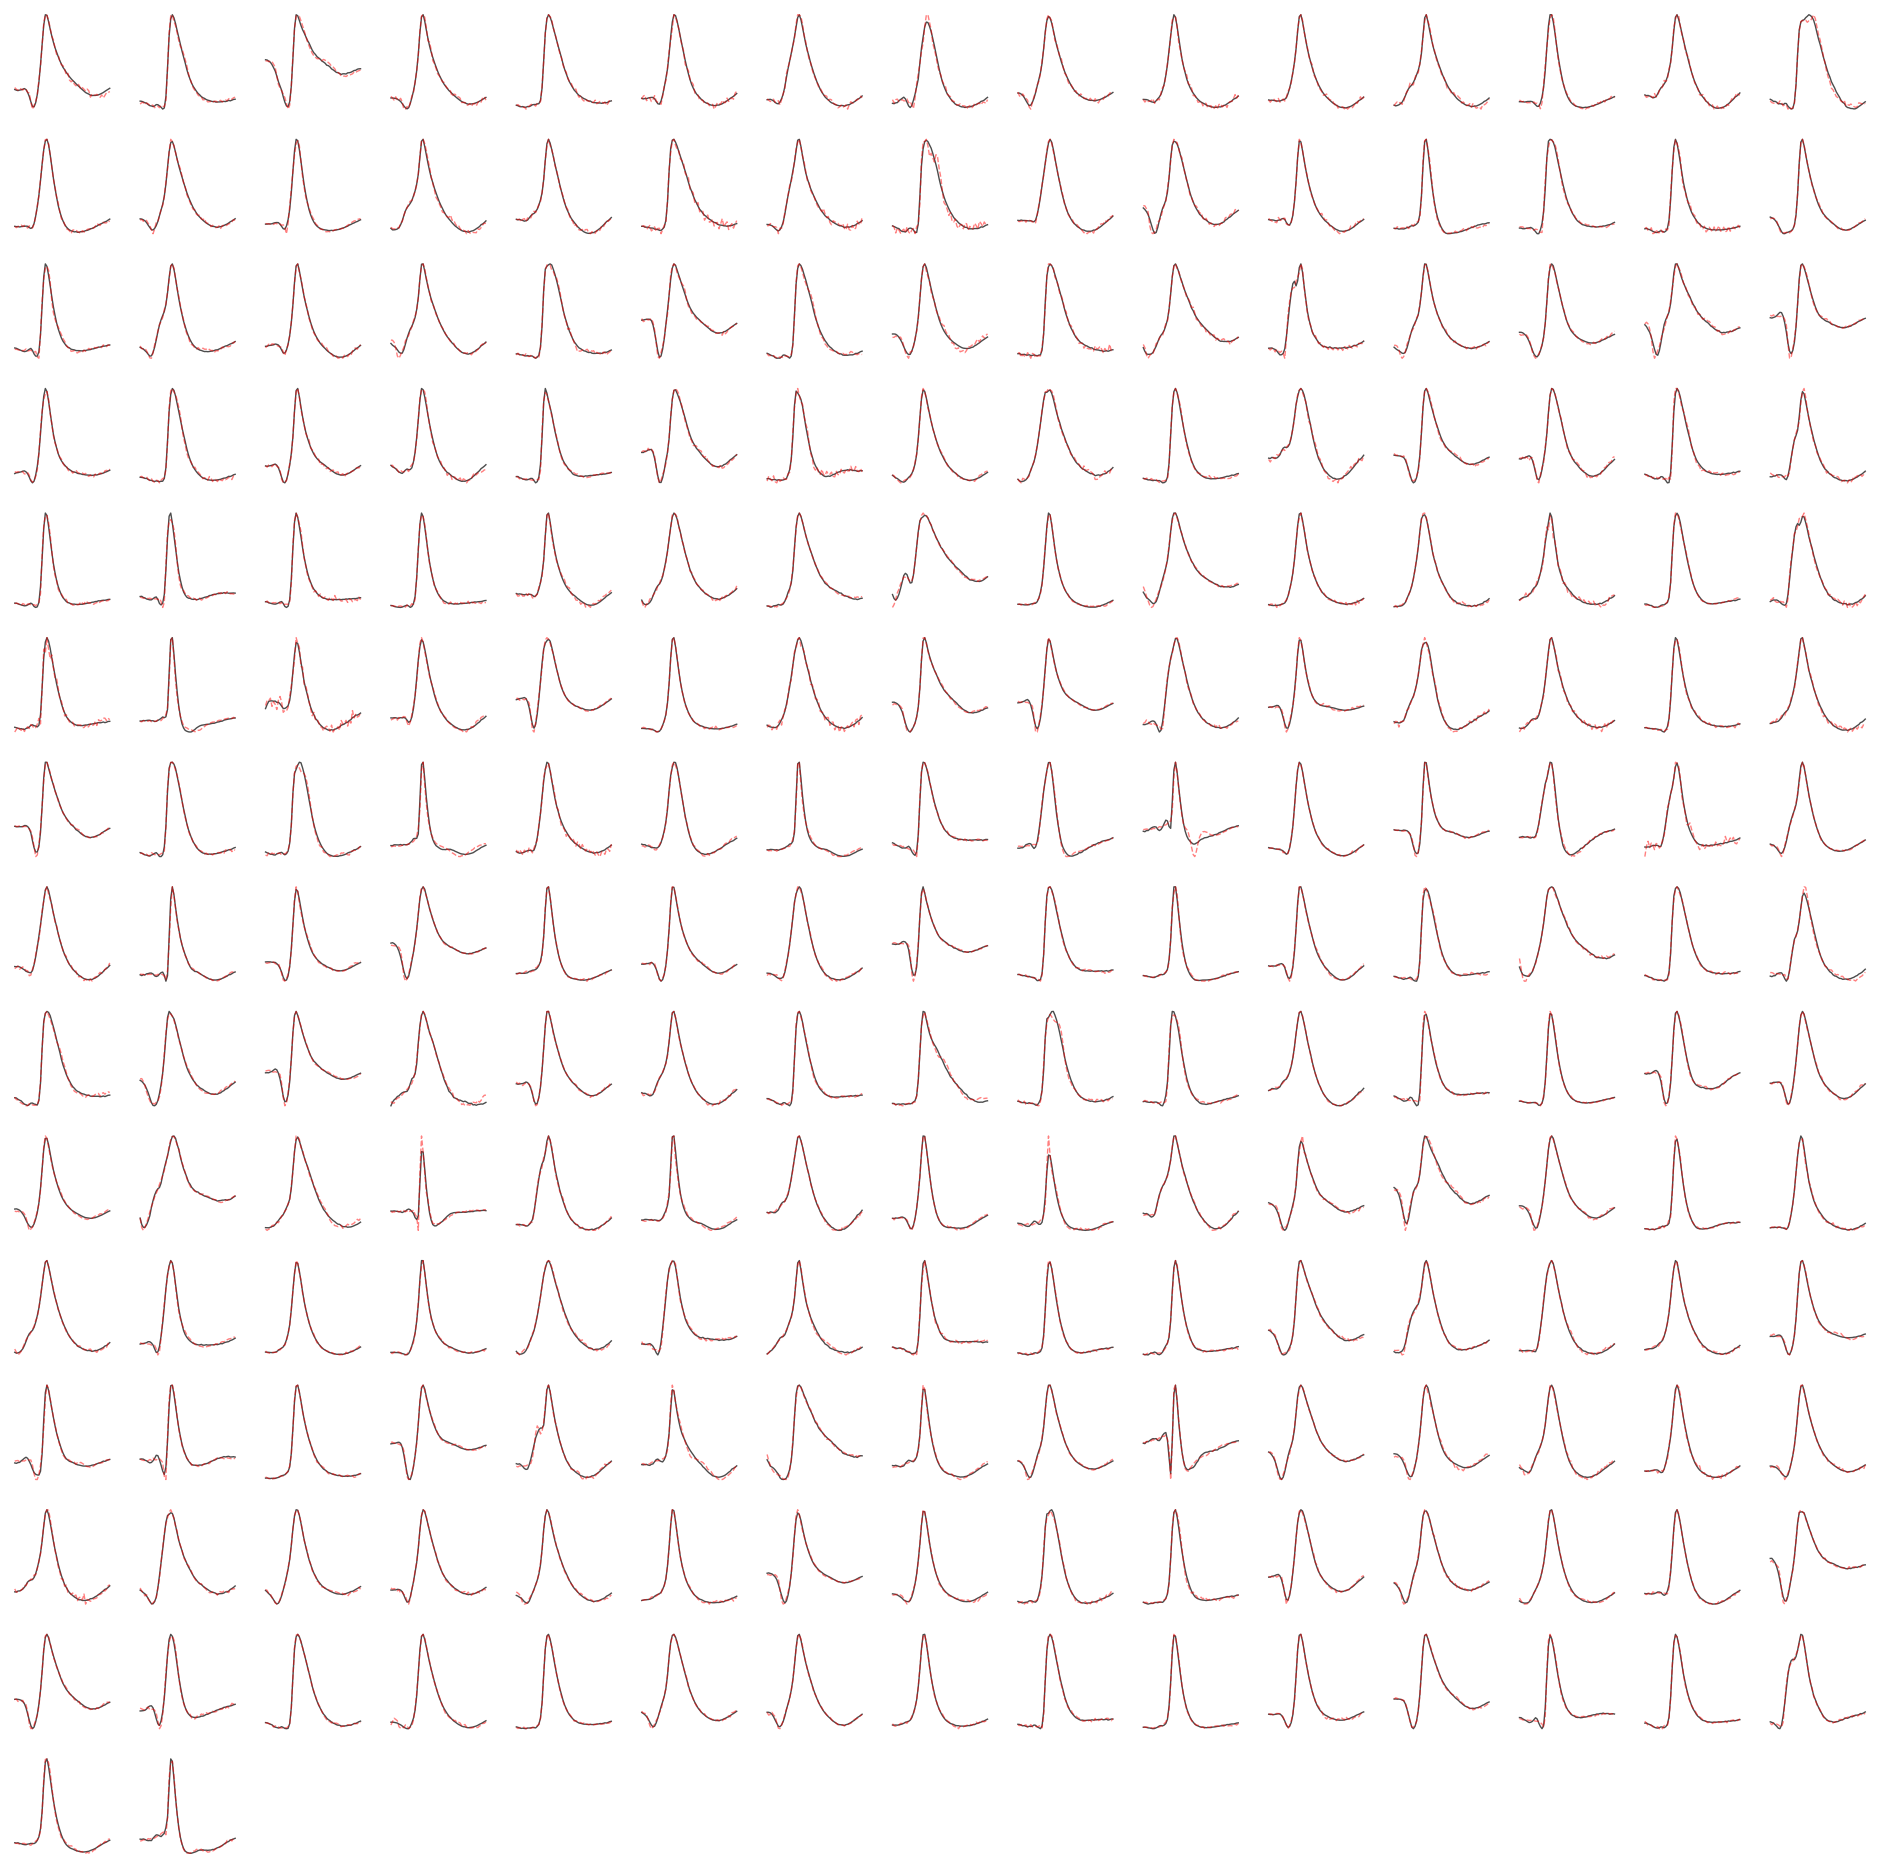

In [233]:
fig = plt.figure(figsize=(24, 24))
gs = gridspec.GridSpec(int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), figure=fig)
for i in range(len(all_wfs_nl_clean)):
    ax = fig.add_subplot(gs[i])
    plt.plot(pc_time, all_wfs_pc[i], alpha=0.7, color='k', linewidth=1);
    plt.plot(pc_time, all_wfs_nl_clean[i], color='r', alpha=0.5, linestyle='--', linewidth=1)
    # turn off the axis
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)    

Explained variance ratios: [0.36694066 0.31812875 0.12713001 0.06119667 0.05637339]


Text(0.5, 1.0, 'Explained Variance by PCA Components')

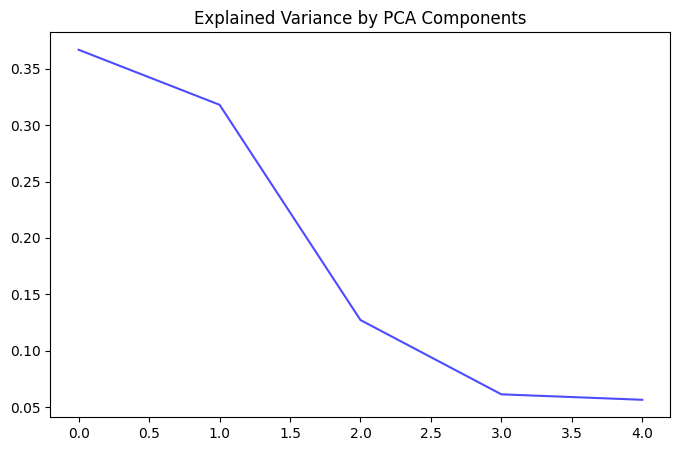

In [245]:
# perform PCA
wf_mat = all_wfs_pc
pca = PCA(n_components=5)  # we can choose the number of components we want
pca_result = pca.fit_transform(wf_mat)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance ratios: {explained_variance}')
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, alpha=0.7, color='blue')
plt.title('Explained Variance by PCA Components')

Text(0, 0.5, 'PC 2')

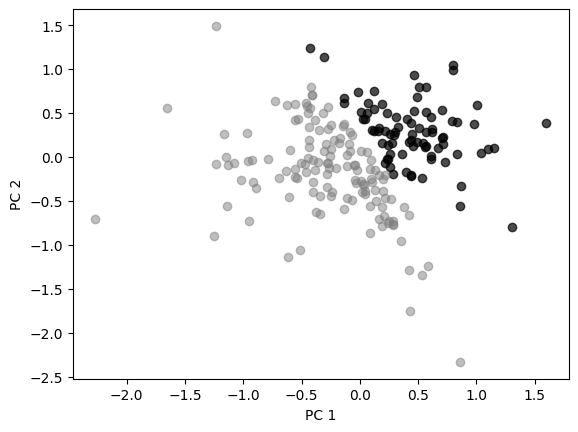

In [249]:
# score = 0.2*pca_result[:, 0] + pca_result[:, 1]
# score = pca_result[:, 0]
score = pca_result[:, 0] + 0.5*pca_result[:, 1]
filter = score > 0.15
plt.scatter(pca_result[filter, 0], pca_result[filter, 1], c = 'k', alpha=0.7)
plt.scatter(pca_result[~filter, 0], pca_result[~filter, 1], c = 'gray', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

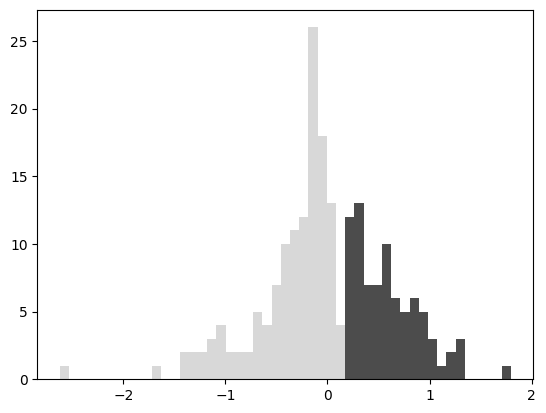

In [250]:
bins = np.linspace(np.min(score), np.max(score), 50)
plt.hist(score[filter], bins=bins, color='k', alpha=0.7);
plt.hist(score[~filter], bins=bins, color='gray', alpha=0.3);

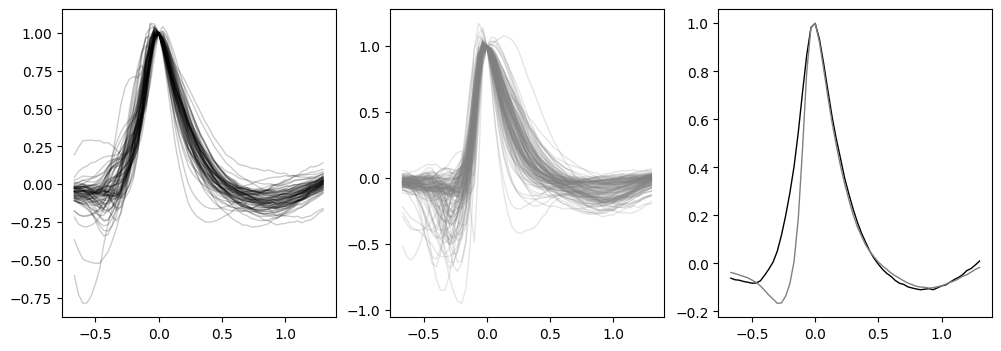

In [248]:
fig = plt.figure(figsize=(12, 4))
wf_time = (np.arange(60) - 20)/30000 * 1000  # assuming 90 samples in the waveform
plt.subplot(1, 3, 1)
plt.plot(wf_time, all_wfs_pc[filter].T, alpha=0.2, linewidth=1, color='k');
plt.subplot(1, 3, 2)
plt.plot(wf_time, all_wfs_pc[~filter].T, alpha=0.2, linewidth=1, color=[0.5, 0.5, 0.5]);  # plot the ones with higher pca values in black
plt.subplot(1, 3, 3)
plt.plot(wf_time, np.mean(all_wfs_pc[filter], axis=0), linewidth=1, color='k');  # plot the ones with higher pca values in black
plt.plot(wf_time, np.mean(all_wfs_pc[~filter], axis=0), linewidth=1, color=[0.5, 0.5, 0.5]);

In [161]:
wf_pc

np.float64(15.0)

In [ ]:
trough_peak = []
trough_peak_dis = []


   

In [8]:
# grab all tagged units and combine a pdf
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
for session, unit, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc:
        session_dir = session_dirs(session)
        # # opto_file
        # all_pdfs = os.listdir(session_dir[f'opto_dir_fig_{data_type}'])
        # pdf = [pdf for pdf in all_pdfs if f'unit_{unit}_' in pdf and pdf.endswith('.pdf')][0]
        # pdf_path = os.path.join(session_dir[f'opto_dir_fig_{data_type}'], pdf)
        # # copy to new path
        # new_path_opto = os.path.join('/root/capsule/scratch/combined/opto_tagged', f'{session}_{pdf}')
        # _ = shutil.copy(pdf_path, new_path_opto)

        # selected_sessions.append(session)
        # selected_units.append(unit)
        # all_pdf.append(pdf_path)

        # # behavior file: go cue
        # all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue'))
        # pdf = [pdf for pdf in all_pdfs if f'unit_{unit}_' in pdf and pdf.endswith('.pdf')][0]
        # pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue', pdf)
        # # copy to new path
        # new_path_ephys = os.path.join('/root/capsule/scratch/combined/behavior_tagged_go_cue', f'{session}_{pdf}')
        # _ = shutil.copy(pdf_path, new_path_ephys)

        # behavior file: go cue
        all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response'))
        pdf = [pdf for pdf in all_pdfs if f'unit_{unit}_' in pdf and pdf.endswith('.pdf')][0]
        pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response', pdf)
        # copy to new path
        new_path_ephys = os.path.join('/root/capsule/scratch/combined/behavior_tagged_response', f'{session}_{pdf}')
        _ = shutil.copy(pdf_path, new_path_ephys)


In [7]:
opto_sessions = []
for session, unit, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc:
        opto_sessions.append(session)

opto_sessions = list(set(opto_sessions))

for session in opto_sessions:
    session_dir = session_dirs(session)
    opto_summary_file = os.path.join(session_dir[f'opto_dir_{data_type}'], f"{session}_{data_type}_{target}_opto_summary.pdf")
    if os.path.exists(opto_summary_file):
        new_path = os.path.join('/root/capsule/scratch/combined/opto_summary', f'{session}_opto_summary.pdf')
        _ = shutil.copy(opto_summary_file, new_path)


In [3]:
opto_sessions = []
for session, unit, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc:
        opto_sessions.append(session)

opto_sessions = list(set(opto_sessions))

for session in opto_sessions:
    session_dir = session_dirs(session)
    waveform_summary_file = os.path.join(session_dir[f'ephys_dir_{data_type}'], "waveforms_recompute.pdf")
    if os.path.exists(waveform_summary_file):
        new_path = os.path.join('/root/capsule/scratch/combined/waveform_summary', f'{session}_waveform_recompute.pdf')
        _ = shutil.copy(waveform_summary_file, new_path)

In [8]:
# combine_pdf_big('/root/capsule/scratch/combined/opto_tagged', os.path.join('/root/capsule/scratch/combined', 'opto_tagged_combined.pdf'))
# combine_pdf_big('/root/capsule/scratch/combined/behavior_tagged_go_cue', os.path.join('/root/capsule/scratch/combined', 'behavior_ephys_tagged_go_cue_combined.pdf'))

# combine_pdf_big('/root/capsule/scratch/combined/behavior_tagged_response', os.path.join('/root/capsule/scratch/combined', 'behavior_ephys_tagged_response_combined.pdf'))
combine_pdf_big('/root/capsule/scratch/combined/opto_summary', os.path.join('/root/capsule/scratch/combined', 'opto_probe_summary.pdf'))

Processing 23 files in /root/capsule/scratch/combined/opto_summary


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 

Combined PDF saved as: /root/capsule/scratch/combined/opto_probe_summary.pdf
